# Can the filtered drag models capture the notion of total work?

Now, we want to start comparing our models against a physical truth. We still want to predict drag force from our input features, but now we want to check that our model is also capturing the notion of total work, which is the integral of drag force over x.

### Import and prepare data

In [3]:
import OpenMORe.OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.OpenMORe.utilities import *
import pandas as pd
from numpy import genfromtxt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

In [4]:
cu4_drag_force = genfromtxt('cu4_drag_force.csv', delimiter=',')

In [5]:
cu4_drag_force = pd.DataFrame(cu4_drag_force, columns=["x","eta","u","v","pressure","deta_dx","drag_force"])
cu4_drag_force

,x,eta,u,v,pressure,deta_dx,drag_force
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395
...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284


In [6]:
cu4_pos_drag = cu4_drag_force.copy()
cu4_neg_drag = cu4_drag_force.copy()

# apply filters for drag force
cu4_pos_drag[cu4_pos_drag['deta_dx'] < 0] = 0
cu4_neg_drag[cu4_neg_drag['deta_dx'] > 0] = 0

### Calculation of real work

The integral of drag force over x is W (work). We can estimate this integral ourselves using the real data.

$W = \int F_{D}dx \approx \sum F_{d}(x_{i})\Delta x$

In [7]:
cu4_drag_force['dx'] = cu4_drag_force['x'].diff()

products = cu4_drag_force['dx'] * cu4_drag_force['drag_force']
real_work = np.sum(products)
real_work

355.83458649274985

### Research questions

- How well do the two models currently predict real work? (this notebook)
- If you add real work error terms in the loss function, do they predict it better? (next notebook: positive_drag_force_with_total_work_constraint)

### Run the models again to have them saved in this notebook

Helper functions.

In [8]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [9]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 3])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

Negative drag model.

In [10]:
# Prepare the data
cu4_neg_drag = cu4_neg_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_neg_drag = cu4_neg_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_neg_drag = cu4_neg_drag.drop(train_dataset_cu4_neg_drag.index)

train_dataset_cu4_neg_drag.pop('pressure')
test_dataset_cu4_neg_drag.pop('pressure')

train_dataset_cu4_neg_drag.pop('deta_dx')
test_dataset_cu4_neg_drag.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_neg_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_neg_drag.shape)

train_features_cu4_neg_drag = train_dataset_cu4_neg_drag.copy()
test_features_cu4_neg_drag = test_dataset_cu4_neg_drag.copy()

train_labels_cu4_neg_drag = train_features_cu4_neg_drag.pop('drag_force')
test_labels_cu4_neg_drag = test_features_cu4_neg_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_neg_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_neg_drag.adapt(np.array(train_features_cu4_neg_drag))

first = np.array(train_features_cu4_neg_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_neg_drag(first).numpy())

# Build the model
dnn_model_cu4_neg_drag = build_and_compile_model(normalizer_cu4_neg_drag)
dnn_model_cu4_neg_drag.summary()

shape of training dataset:  (8191, 5)
shape of testing dataset:  (2048, 5)


2022-12-07 15:05:52.772463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First example: [[0.9  1.54 1.13 1.02]]

Normalized: [[1.43 2.19 1.32 1.13]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [11]:
%%time
history_cu4_neg_drag = dnn_model_cu4_neg_drag.fit(
    train_features_cu4_neg_drag,
    train_labels_cu4_neg_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 38.4 s, sys: 6.8 s, total: 45.2 s
Wall time: 29.7 s


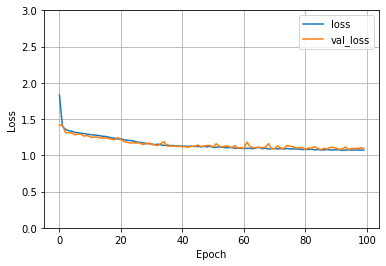

In [12]:
plot_loss(history_cu4_neg_drag)

Set epochs=1000 and you get an example of overfitting! Might be nice to include in your paper to say that you kept an eye out for this one. Regularly set epochs=100. Honestly, there seems to be a bit of overfitting here, but we will ignore that for now.

Positive drag model.

In [13]:
# Prepare the data
cu4_pos_drag = cu4_pos_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_pos_drag = cu4_pos_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_pos_drag = cu4_pos_drag.drop(train_dataset_cu4_pos_drag.index)

train_dataset_cu4_pos_drag.pop('pressure')
test_dataset_cu4_pos_drag.pop('pressure')

train_dataset_cu4_pos_drag.pop('deta_dx')
test_dataset_cu4_pos_drag.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_pos_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_pos_drag.shape)

train_features_cu4_pos_drag = train_dataset_cu4_pos_drag.copy()
test_features_cu4_pos_drag = test_dataset_cu4_pos_drag.copy()

train_labels_cu4_pos_drag = train_features_cu4_pos_drag.pop('drag_force')
test_labels_cu4_pos_drag = test_features_cu4_pos_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_pos_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_pos_drag.adapt(np.array(train_features_cu4_pos_drag))

first = np.array(train_features_cu4_pos_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_pos_drag(first).numpy())

# Build the model
dnn_model_cu4_pos_drag = build_and_compile_model(normalizer_cu4_pos_drag)
dnn_model_cu4_pos_drag.summary()

shape of training dataset:  (8191, 5)
shape of testing dataset:  (2048, 5)
First example: [[0. 0. 0. 0.]]

Normalized: [[-0.16 -0.01  0.46  0.41]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_____________________________________

In [14]:
%%time
history_cu4_pos_drag = dnn_model_cu4_pos_drag.fit(
    train_features_cu4_pos_drag,
    train_labels_cu4_pos_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 37 s, sys: 6.71 s, total: 43.7 s
Wall time: 27.9 s


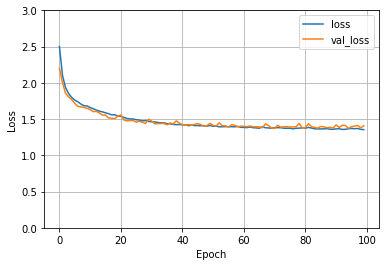

In [15]:
plot_loss(history_cu4_pos_drag)

### Research question 1: how well do the filtered drag force models predict total work?

In [16]:
drag_force_input = cu4_drag_force[['x','eta','u','v']][1:] # doesn't use deta_dx

First, we will calculate the work predicted by the positive drag model.

In [17]:
predicted_pos_drag_force = dnn_model_cu4_pos_drag.predict(drag_force_input)
predicted_pos_drag_force.shape

320/320 [==============================] - 0s 1ms/step


(10239, 1)

In [18]:
predicted_pos_drag_force.shape

(10239, 1)

In [19]:
true_values = np.expand_dims(np.array(cu4_pos_drag['drag_force']), axis=1)
true_values.shape

(10239, 1)

In [20]:
np.sum(np.abs(true_values - predicted_pos_drag_force)) / len(true_values) # mean absolute err for these predictions -> pretty high

3.403273047797759

In [21]:
drag_force_input['dx'] = drag_force_input['x'].diff()

products = drag_force_input['dx'] * np.squeeze(predicted_pos_drag_force)
real_work = np.sum(products)
real_work

232.15029463894427

The real work value was 355.83458649274985. This value is 346.7291874600445. Therefore, we have a percent error of 2.56%. This is super surprising to me. It's such a small percent error! Actually, if you think about it, I bet **it's because we are making predictions on datapoints that we have already trained for.**

In [22]:
np.abs((346.7291874600445 - 355.83458649274985) / 355.83458649274985) * 100

2.558885329965212

That was for positive drag force. What about negative drag force?

In [23]:
drag_force_input = cu4_drag_force[['x','eta','u','v']][1:] # doesn't use deta_dx

predicted_neg_drag_force = dnn_model_cu4_neg_drag.predict(drag_force_input)

320/320 [==============================] - 0s 1ms/step


In [24]:
predicted_neg_drag_force.shape

(10239, 1)

In [25]:
true_values = np.expand_dims(np.array(cu4_neg_drag['drag_force']), axis=1)
true_values.shape

(10239, 1)

In [26]:
np.sum(np.abs(true - predicted_neg_drag_force)) / len(true) # mean absolute err for these predictions -> really high

NameError: name 'true' is not defined

In [27]:
drag_force_input['dx'] = drag_force_input['x'].diff()

products = drag_force_input['dx'] * np.squeeze(predicted_neg_drag_force)
real_work = np.sum(products)
real_work

260.0388990537924

Note that this value doesn't necessarily have to be negative, since some drag_forces are negative and some are positive. Remember that we filtered drag force by deta_dx being positive/negative, not drag_force itself.

Okay, now this total work estimate is WAY off. The error is huge: 96.69%! It's weird, because you would have thought that the results would be similar to the positive drag force predictions (very small error), but this is not the case.

In [28]:
np.abs((11.768339435167162 - 355.83458649274985) / 355.83458649274985) * 100

96.69274997937646

Note: I would have thought that the total work would be way off for both models, though. I would have thought that both are estimating a portion of the overall work, and that you'd have to add the predicted work for both models in order to get the total predicted work across the models, or something like that.

Does it make sense to add them? I am not sure it makes complete physical sense. It is not like you are training on only half of the dataset. You've just zeroed out half of the values that you are trying to predict, in both cases. You get a teensy tiny error of 0.75% though, if you add them.

In [29]:
np.abs((11.768339435167162 + 346.7291874600445 - 355.83458649274985) / 355.83458649274985) * 100

0.7483646906583257

This isn't really a great estimate of how good our models are currently at predicting total work, though. (But the code is good, so I'll keep it around, for now). This is because the models have been trained on most of the data that I've been passing in. So I need to redo these steps, but with entirely new data. This can either be data that I acquire, or I can train the models instead on a smaller subset of data and leave a set of datapoints out for testing.

### Test true total work predictions

Before, we tested how well our two drag force models predicted total work. But the issue we saw was that we were using the model to predict outcomes that we had previously trained on, which probably gave us buggy results. For one of the models, we got a super small percent error of around 2.5%, which was not expected at all! We should only do the testing on our test dataset.

In [30]:
# Uncomment the following to inspect them

#test_features_cu4_neg_drag = test_features_cu4_neg_drag[['x','eta','u','v']]
#test_dataset_cu4_neg_drag
#test_features_cu4_neg_drag
#test_labels_cu4_neg_drag

Here are our actual results now:

In [31]:
predicted_neg_drag_force = dnn_model_cu4_neg_drag.predict(test_features_cu4_neg_drag)

64/64 [==============================] - 0s 1ms/step


In [32]:
predicted_neg_drag_force.shape

(2048, 1)

In [33]:
true_neg_drag_force = np.expand_dims(test_labels_cu4_neg_drag, axis=1)
true_neg_drag_force.shape

(2048, 1)

In [34]:
print("average drag force: ", np.average(test_labels_cu4_neg_drag))
print("standard deviation of drag force: ", np.std(test_labels_cu4_neg_drag))

average drag force:  2.130703474278678
standard deviation of drag force:  4.596920434826871


In [35]:
# mean absolute err for these predictions -> kinda high
np.sum(np.abs(true_neg_drag_force - predicted_neg_drag_force)) / len(predicted_neg_drag_force) 

1.16891422362318

The mean absolute error is about 3.12, which is concerning because the average drag force is about 2.13. This means that the model may sometimes be predicting negative drag when it should be positive, and vice versa. And the sign is important here because of the physical implications. But the standard deviation is about 4.6, which makes me feel a bit better about the mean absolute error.

In [36]:
test_features_cu4_neg_drag['dx'] = test_features_cu4_neg_drag['x'].diff()
test_features_cu4_neg_drag

,x,eta,u,v,dx
1,-1.721907,1.592266,0.258540,0.806480,NaN
14,-1.633949,1.105053,0.588292,1.079666,0.087958
22,-1.579821,0.517113,0.885603,1.000114,0.054128
26,-1.552759,0.274601,1.053696,0.935484,0.027061
27,-1.545991,0.202614,1.132054,0.850646,0.006768
...,...,...,...,...,...
10208,0.000000,0.000000,0.000000,0.000000,0.000000
10212,0.000000,0.000000,0.000000,0.000000,0.000000
10222,0.000000,0.000000,0.000000,0.000000,0.000000
10224,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
test_features_cu4_neg_drag['dx'] = test_features_cu4_neg_drag['x'].diff()

products = test_features_cu4_neg_drag['dx'] * test_labels_cu4_neg_drag
products
real_work = np.sum(products)
real_work

177.07711266571613

In [38]:
products = test_features_cu4_neg_drag['dx'] * np.squeeze(predicted_neg_drag_force)
predicted_work = np.sum(products)
predicted_work

166.98329149263864

The total work comparison is almost spot on! And this is only on testing data, which means that the model didn't train on any of this data. It is a bit surprising to me how closely these two values match. The percent error is 1.03%!

In [40]:
np.abs((178.90129747624377 - 177.07711266571613) / 177.07711266571613) * 100

1.0301640810979975

Let's see how the same process unfolds for the positive drag force model.

In [41]:
predicted_pos_drag_force = dnn_model_cu4_pos_drag.predict(test_features_cu4_pos_drag)

64/64 [==============================] - 0s 1ms/step


In [42]:
predicted_pos_drag_force.shape

(2048, 1)

In [43]:
true_pos_drag_force = np.expand_dims(test_labels_cu4_pos_drag, axis=1)
true_pos_drag_force.shape

(2048, 1)

In [44]:
print("average drag force: ", np.average(test_labels_cu4_pos_drag))
print("standard deviation of drag force: ", np.std(test_labels_cu4_pos_drag))

average drag force:  3.0289498011373026
standard deviation of drag force:  5.888705980783494


In [45]:
# mean absolute err for these predictions -> very small!
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force)) / len(predicted_pos_drag_force)

1.4519532277166278

The mean absolute error is about 1.41, which is less concerning than before because the average drag force is about 3.03. This means that the model may sometimes (but not super frequently) be predicting negative drag when it should be positive, and vice versa. And the sign is important here because of the physical implications.

In [46]:
test_features_cu4_pos_drag['dx'] = test_features_cu4_pos_drag['x'].diff()

products = test_features_cu4_pos_drag['dx'] * test_labels_cu4_pos_drag
real_work = np.sum(products)
real_work

214.3815980222052

In [47]:
products = test_features_cu4_pos_drag['dx'] * np.squeeze(predicted_pos_drag_force)
predicted_work = np.sum(products)
predicted_work

211.67199522076766

The total work comparison is way closer than before (thank God lol). The percent error is about 16.7%. This could definitely be improved, though.

In [48]:
np.abs((predicted_work - real_work) / real_work) * 100

1.263915758831542

I wonder why it was easier for the filtered drag force model output's total work to match the real total work for negative drag than for positive drag.

Here is an issue, though: we are doing this as compared to the FILTERED drag forces. Don't we need to compare the output for the real values, instead?

### True total work predictions against unfiltered drag force values

Recall that cu4_neg_drag was copied from cu4_drag_force. And the test_features_cu4_neg_drag were sampled from cu4_neg_drag. That means that we can use the indices of the test_features_cu4_neg_drag to map back to the original data (cu4_drag_force). That means that we can get the unfiltered drag force values for all of our testing datapoints!

In [49]:
test_features_cu4_neg_drag.index

Int64Index([    1,    14,    22,    26,    27,    28,    29,    36,    42,
               44,
            ...
            10178, 10192, 10196, 10201, 10202, 10208, 10212, 10222, 10224,
            10238],
           dtype='int64', length=2048)

In [50]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_neg_drag.index)]['drag_force']
true_drag_force = np.expand_dims(true_drag_force, axis=1)
true_drag_force.shape

(2048, 1)

In [51]:
# Uncomment the following to inspect them

test_features_cu4_neg_drag = test_features_cu4_neg_drag[['x','eta','u','v']]
#test_dataset_cu4_neg_drag
#test_features_cu4_neg_drag
#test_labels_cu4_neg_drag

In [52]:
predicted_neg_drag_force = dnn_model_cu4_neg_drag.predict(test_features_cu4_neg_drag)

64/64 [==============================] - 0s 1ms/step


In [53]:
predicted_neg_drag_force.shape

(2048, 1)

In [54]:
print("average drag force: ", np.average(test_labels_cu4_neg_drag))
print("standard deviation of drag force: ", np.std(test_labels_cu4_neg_drag))

average drag force:  2.130703474278678
standard deviation of drag force:  4.596920434826871


In [55]:
# mean absolute err for these predictions -> higher than previous, which is definitely expected
np.sum(np.abs(true_neg_drag_force - predicted_neg_drag_force)) / len(predicted_neg_drag_force) 

1.16891422362318

In [56]:
test_features_cu4_neg_drag['dx'] = test_features_cu4_neg_drag['x'].diff()

products = test_features_cu4_neg_drag['dx'] * np.squeeze(true_drag_force)
products
real_work = np.sum(products)
real_work

175.82545366605143

In [57]:
products = test_features_cu4_neg_drag['dx'] * np.squeeze(predicted_neg_drag_force)
predicted_work = np.sum(products)
predicted_work

166.98329149263864

***NEGATIVE DRAG FORCE MODEL RESULT***. The total work comparison is almost spot on! And this is only on testing data, which means that the model didn't train on any of this data. It is a bit surprising to me how closely these two values match. The percent error is 1.03%!

In [58]:
np.abs((178.90129747624377 - 177.07711266571613) / 177.07711266571613) * 100

1.0301640810979975

How does the positive filtered drag model do?

In [59]:
test_features_cu4_pos_drag.index

Int64Index([    1,    14,    22,    26,    27,    28,    29,    36,    42,
               44,
            ...
            10178, 10192, 10196, 10201, 10202, 10208, 10212, 10222, 10224,
            10238],
           dtype='int64', length=2048)

In [60]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_pos_drag.index)]['drag_force']
true_drag_force = np.expand_dims(true_drag_force, axis=1)
true_drag_force.shape

(2048, 1)

In [61]:
# Uncomment the following to inspect them

test_features_cu4_pos_drag = test_features_cu4_pos_drag[['x','eta','u','v']]
#test_dataset_cu4_pos_drag
#test_features_cu4_pos_drag
#test_labels_cu4_pos_drag

In [62]:
predicted_pos_drag_force = dnn_model_cu4_pos_drag.predict(test_features_cu4_pos_drag)

64/64 [==============================] - 0s 1ms/step


In [63]:
predicted_pos_drag_force.shape

(2048, 1)

In [64]:
print("average drag force: ", np.average(test_labels_cu4_pos_drag))
print("standard deviation of drag force: ", np.std(test_labels_cu4_pos_drag))

average drag force:  3.0289498011373026
standard deviation of drag force:  5.888705980783494


In [65]:
# mean absolute err for these predictions (can also compare against true_drag_force instead of true_pos_drag_force)
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force)) / len(predicted_pos_drag_force) 

1.4519532277166278

In [66]:
test_features_cu4_pos_drag['dx'] = test_features_cu4_pos_drag['x'].diff()

products = test_features_cu4_pos_drag['dx'] * np.squeeze(true_drag_force)
products
real_work = np.sum(products)
real_work

265.87685748857706

In [67]:
products = test_features_cu4_pos_drag['dx'] * np.squeeze(predicted_pos_drag_force)
predicted_work = np.sum(products)
predicted_work

211.67199522076766

In [68]:
np.abs((predicted_work - real_work) / real_work) * 100

20.387205859065123

***POSITIVE DRAG FORCE MODEL RESULT***. Unlike the previous model, the total predicted work is pretty far off from the total real work. The percent error is about 32.9%. Maybe this goes back to what we were talking about a few weeks ago in the meeting, where the front of the wave only exerts negative force, but the back of the wave has postive and negative forces applied because of the little wind eddies. So the positive force relationship is slightly harder to learn? This doesn't exactly match with our conclusions from the DNNs, which is that both relationships are similarly learnable (negative drag model converged to a MAE loss of about 1.1, whereas postiive drag model converged to an MAE loss of about 1.4, which is very similar).

### Comparing force predictions

For the negative drag model, we will compare the real work predictions with more granularity. 

Plot of true drag force against predicted negative drag force.

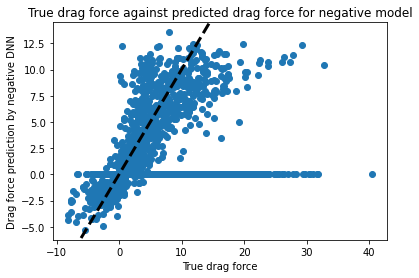

In [69]:
plt.scatter(true_drag_force, predicted_neg_drag_force)
plt.title("True drag force against predicted drag force for negative model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by negative DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

Ideally, we would want all points to lie along the y=x line (true drag force would equal predicted drag force, in that case). We can see here that the negatie DNN predicts many drag forces to be 0, regardless of their true value. These roughly correspond to the points that have been zeroed-out in the training dataset (model's estimates). The other points may not lie exactly on the y=x line due to the natural imperfectness of the model on new datapoints.

Here is the case for the DNN trained on the positive drag force. We also see a lot of 0 predictions.

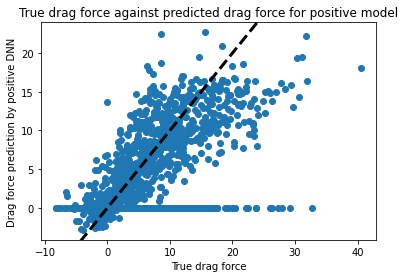

In [71]:
plt.scatter(true_drag_force, predicted_pos_drag_force)
plt.title("True drag force against predicted drag force for positive model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by positive DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

In [81]:
my_df = pd.DataFrame([np.squeeze(true_drag_force), np.squeeze(predicted_neg_drag_force),np.squeeze(predicted_pos_drag_force)]).T
my_df

,0,1,2
0,-0.209920,-1.669400,-0.016417
1,0.100043,-1.007283,-0.016417
2,3.262955,4.134096,-0.016417
3,2.834713,6.009842,-0.016417
4,6.334178,6.104504,-0.016417
...,...,...,...
2043,7.784577,0.014895,10.032746
2044,16.422499,0.014895,12.424960
2045,7.530309,0.014895,15.055795
2046,7.102939,0.014895,14.939099


In [84]:
np.savetxt("graphic2.csv", my_df, delimiter=",")